# Fast-Fourier Transform (FFT)

- Andrew J. Graves
- 12/1/20

## Introduction

The Fast-Fourier Transform (FFT) was one of the most important algorithms developed in the $20^{th}$ century. The FFT is still widely used in modern computing, as it is an excellent algorithm for compression, digital communications, and analyzing time-series data. The factorization that makes the FFT much faster than a brute-force implementation of the Discrete Fourier Transform (DFT) was originally identified by Gauss in 1805. The implementation of this efficient factorization on "modern" computers, however, was popularized by Cooley and Tukey in 1965. The FFT is a classic example of the divide-and-conquer technique, from which the complexity of the straightforward solution to the DFT is reduced from $\Theta(n^2)$ down to $\Theta(n \lg n)$ for the FFT.

In [1]:
# Import modules
import math
import cmath
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Format plots
%matplotlib inline
from IPython.display import set_matplotlib_formats
mpl.rcParams['figure.dpi'] = 300
set_matplotlib_formats('png', 'pdf')

# Random test array
x = np.random.random(1024) # 2 ** 10

## Mathematical description of the DFT

In order to compute the DFT, we evaluate the polynomial $A(x) = \sum_{j=0}^{n-1}a_jx^j$ at $\omega_n^0, \omega_n^1, \dots, \omega_n^{n-1}$ such that

$$A(\omega_n^k) = \sum_{j=0}^{n-1}a_j\omega_n^{kj}$$

We can express the DFT as a matrix-vector product $\textbf{y} = \textbf{V}_n\textbf{a}$, where $\textbf{V}_n$ is the Vandermonde matrix with the geometric progression and appropriate powers of $\omega_n$, $\textbf{a}$ is the coefficient vector, and $\textbf{y}$ is the computed results for the DFT.

$$\begin{pmatrix}
y_0 \\
y_1 \\
y_2 \\
y_3 \\
\vdots \\
y_{n-1}
\end{pmatrix} = 
\begin{pmatrix}
1 & 1 & 1 & 1 & \cdots & 1\\
1 & \omega_n & \omega_n^2 & \omega_n^3 & \cdots & \omega_n^{n-1}\\
1 & \omega_n^2 & \omega_n^4 & \omega_n^6 & \cdots & \omega_n^{2(n-1)} \\
1 & \omega_n^3 & \omega_n^6 & \omega_n^9 & \cdots & \omega_n^{3(n-1)}\\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
1  & \omega_n^{n-1} & \omega_n^{2(n-1)} & \omega_n^{3(n-1)} & \cdots & \omega_n^{(n-1)(n-1)}
\end{pmatrix}
\begin{pmatrix}
a_0 \\
a_1 \\
a_2 \\
a_3 \\
\vdots \\
a_{n-1}
\end{pmatrix}$$

## Brute-force Implementation: $\Theta(n^2)$

In [2]:
# Brute-force solution for Discrete Fourier Transform (DFT)
def dft(a):
    n = len(a) # signal length
    # Initialize omega matrix
    omega = np.zeros([n, n], dtype='complex')
    # Traverse the matrix
    for i in range(n):
        for j in range(n):
            # Compute the DFT
            omega[i, j] = np.exp(-2j * math.pi * j * i / n)
    return omega @ a # DFT matrix-vector product

%timeit dft(x) # prohibitively slow

1.63 s ± 153 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Recursive divide-and-conquer implementation: $\Theta(n \lg n)$

In [3]:
# Divide-and-conquer to solve DFT recursively 
def recursive_fft(a):
    
    # Notation and implementation follows the CLSR description (Ch 30)
    
    n = len(a) # signal length must be a power of 2 for this implementation!
    
    # Base case
    if n == 1:
        return a
    
    # Initialize output
    y = [None] * n
    
    # Initialize omega
    omega_n = cmath.exp(2 * cmath.pi * -1j / n)
    omega = 1
    
    # Divide-and-conquer partition
    a0 = a[::2] # elements of even indices
    a1 = a[1::2] # elements of odd indices
    
    # Recursion routine
    y0 = recursive_fft(a0) # evens
    y1 = recursive_fft(a1) # odds
    
    # Compute the DFT
    for k in range(n//2):
        t = omega * y1[k] # get current constant
        
        # Store results
        y[k] = y0[k] + t
        y[k + n//2] = y0[k] - t
        omega = omega * omega_n # update omega
    return np.array(y)

%timeit recursive_fft(x) # much faster than brute-force

12.1 ms ± 1.95 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Iterative divide-and-conquer implementation: $\Theta(n \lg n)$

In [4]:
# Bit-reversal routine
def bit_reverse_copy(a, n):
    
    # Initialize output
    A = [None] * n
    
    # Perform bit-reversal for lgn
    # Borrowed this lambda function form the following link:
    # https://codegolf.stackexchange.com/questions/83373/bit-reversal-permutations
    bit_rev = lambda n:[0][n:]or[i+j*2 for i in (0,1) for j in bit_rev(n-1)]
    bit_perm = bit_rev(int(math.log2(n)))
    
    # Reassign vector values to the correct index based on bit-reversal
    for k in range(n):
        A[bit_perm[k]] = a[k]
    return A

# Divide-and-conquer to solve DFT recursively 
def iterative_fft(a):
    
    # Notation and implementation follows the CLSR description (Ch 30)
    
    n = len(a) # signal length: must be a power of 2 for this implementation!
    # Invokes bit reversal routine to properly index A
    A = bit_reverse_copy(a, n)
    
    # Iterate through to the power that raises 2 to equal n
    for s in range(1, int(math.log2(n)) + 1):
        m = 2 ** s # compute the current power of 2
        # Get current omega
        omega_m = cmath.exp(2 * cmath.pi * -1j / m)
        # Iterate through the vector with power step sizes
        for k in range(0, n, m):
            omega = 1 # initialize omega
            # Divide-and-conquer partition
            for j in range(m//2):
                t = omega * A[k + j + m//2] # omega * A product traversal
                u = A[k + j] # get current constant for DFT
                # Store results
                A[k + j] = u + t 
                A[k + j + m//2] = u - t
                omega = omega * omega_m # Update omega
    return np.array(A)

%timeit iterative_fft(x) # slightly faster than recursion (lower constants)

9.99 ms ± 566 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Numpy implementation: $\Theta(n \lg n)$

In [5]:
# Optimized numpy implementation: much faster than all!
%timeit np.fft.fft(x) # FFTPACK and vectorization wins

18.3 µs ± 1.95 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Test accuracy of results

In [6]:
# Verification that my three implementations match numpy implementation
my_fft = [dft(x), recursive_fft(x), iterative_fft(x)]

# This should output 3 True values
for i in my_fft:
    # Tests equality w/ low tolerance
    print(np.allclose(i, np.fft.fft(x), atol=1e-16))

True
True
True


## Simulate a time-series

In [7]:
# Function for generating simple sine wave
def get_sine_wave(frequency, srate, amplitude=1, start_time=-1, end_time=1):
    # Time series
    time = np.arange(start_time, end_time + 1 / srate, 1 / srate)
    return amplitude * np.sin(2 * np.pi * frequency * time)

# Set seed
np.random.seed(42)

# Simulation parameters
time_points = 1024
mu = 0 # Gaussian mu
sigma = 1 # Gaussian sd

# Initialize output
out = np.zeros(time_points)

# Set frequency family
freq_fam = np.linspace(10, 50, 5)

# Iterate through the frequencies
for i in freq_fam:
    # Generate sine waves for select signal locations
    sig = get_sine_wave(frequency=i, srate=time_points, amplitude=1, 
                        start_time=0, end_time=.999)
    # Generate Gaussian noise
    noise_arr = np.random.normal(mu, sigma, out.shape)
    # Add noise to the signal and store in output
    out += sig + noise_arr

## Plot the simulation results

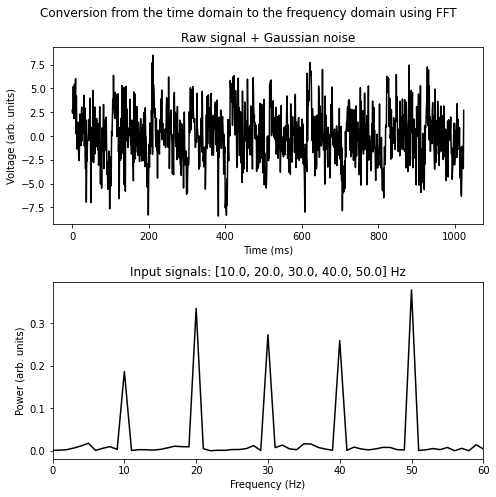

In [8]:
frequencies = np.linspace(0, time_points // 2, len(out) // 2 + 1)
fft_sig = iterative_fft(out) / len(out)
power = np.abs(fft_sig[0:len(frequencies)]) ** 2

fig, ax = plt.subplots(2,1, figsize=(7,7))

ax[0].plot(out, color='black')
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Voltage (arb. units)')
ax[0].set_title('Raw signal + Gaussian noise')

ax[1].plot(frequencies, power, color='black')
ax[1].set_xlim([0, max(freq_fam)+min(freq_fam)])
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Power (arb. units)')
ax[1].set_title(f'Input signals: {[i for i in freq_fam]} Hz')

fig.suptitle('Conversion from the time domain to the frequency domain using FFT')
fig.tight_layout()